# <center> A1: Data Curation </center>
<center> David Wei </center>
<center> DATA 512, 2019-09-28 </center>

## Overview ##
This is the main session with detailed working code. The workflow contains API requests to Wikimedia's endpoints, data aggregation, and data visualization/analysis. The whole worksheet and outputs should be easily reproducible based on the documentation.

The code should be self-explanatory as I intend to use clean and DRY code as documentation. I will provide documentation for parts that contains logic.

## Goal ##
The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2019. All analysis are be performed in a single Jupyter notebook and all data, documentation, and code are published in a single GitHub repository.

The purpose of the assignment show the best practices for open scientific research in designing and implementing your project, and make the project fully reproducible by others: from data collection to data analysis.

For details, see https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments#A1:_Data_curation

### Step 0: Read about reproducibility ###
Review Chapter 2 "Assessing Reproducibility" and Chapter 3 "The Basic Reproducible Workflow Template" from The Practice of Reproducible Research University of California Press, 2018.

### Step 1: Data acquisition ###

This section defines all methods required to perform the workflow. Details explanations are inline.

The first three methods, `build_legacy_params`, `build_params`, and `api_call`, are used to make the API request to Wikimedia, and the last three methods, `output_raw_data`, `short_date`, and `aggregate_metrics`,  are required to aggregate metrics and generate outputs.

Python libraries used: `json`, `requests`, `copy`

In [1]:
import json
import requests
import copy

# Specify endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
# Specify my request header
headers = {
    'User-Agent': 'https://github.com/ywei1',
    'From': 'ywei1@uw.edu'
}

def build_legacy_params(access_site, start, end, project="en.wikipedia.org",
                       granularity="monthly"):
    # see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
    params = {"project" : project,
                     "access-site" : access_site,
                     "granularity" : granularity,
                     "start" : start,
                     # for end use 1st day of month following final month of data
                     "end" : end
                        }
    return params

def build_params(access, start, end, agent="user", project="en.wikipedia.org",
                granularity="monthly"):
    # see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
    params = {"project" : project,
                        "access" : access,
                        "agent" : agent, # limit to organic traffic by filtering out web crawler
                        "granularity" : granularity,
                        "start" : start,
                        # for end use 1st day of month following final month of data
                        "end" : end
                            }
    return params

# Error handling is not required for this assignment
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

# Write the raw output of the api response to a json file under raw_output directory
def output_raw_data(access, start_date, end_date, is_legacy):
    if is_legacy:
        # desktop-site, mobile-site
        legacy_params = build_legacy_params(access_site=access, start=start_date, end=end_date)
        res = api_call(endpoint_legacy, legacy_params)
        file_name = "raw_output/pagecounts_{0}_200712-201908.json".format(access)
    else:
        # desktop, mobile-app, mobile-web
        params = build_params(access=access, start=start_date, end=end_date)
        res = api_call(endpoint_pageviews, params)
        file_name = "raw_output/pageviews_{0}_200712-201908.json".format(access)
        
    f = open(file_name, "w")
    f.write(json.dumps(res))
    f.close()
    
    return res

# convert long data string to just YYYYMM:
# 2018010200 -> 201801
def short_date(date):
    return date[0:6]

# Given a source_data, fill in output data
def aggregate_metrics(source_data, existing_data, metric_name):
    output = copy.deepcopy(existing_data)
    for item in source_data['items']:
        if short_date(item['timestamp']) not in output:
            output[short_date(item['timestamp'])] = item[metric_name]
        else:
            output[short_date(item['timestamp'])] += item[metric_name]
    return output

This is the place where we make API requests. For each endpoint, there will be multiple API calls.

- Legacy Pagecount endpoint has two access types: `desktop-site` and `mobile-site`
- Pageview endpoint has three access types: `desktop`, `mobile-app`, and `mobile-web`

The output of this step are 5 json files stored under `raw_output` directory.
- pagecounts_desktop-site_200712-201908.json
- pageviews_mobile-app_200712-201908.json
- pagecounts_mobile-site_200712-201908.json
- pageviews_mobile-web_200712-201908.json
- pageviews_desktop_200712-201908.json
Their names follow the naming format: `apiname_accesstype_firstmonth-lastmonth.json`

In [2]:
start_date = "2007120100"
end_date = "2019090100"
pagecount_desktop = output_raw_data("desktop-site", start_date, '2016073100', is_legacy=True)
pagecount_mobile = output_raw_data("mobile-site", start_date, '2016073100', is_legacy=True)
pageview_desktop = output_raw_data("desktop", start_date, end_date, is_legacy=False)
pageview_mobile_app = output_raw_data("mobile-app", start_date, end_date, is_legacy=False)
pageview_mobile_web = output_raw_data("mobile-web", start_date, end_date, is_legacy=False)

### Step 2: Data processing

In this step we performed a series of actions to transform the raw data into well-structured dataset for later analysis. In short, there are two steps:

- For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
- For both pagecount and pageview dataset, generate a total_count or total_view dataset by adding up desktop data and mobile data.

Here we use the `aggregate_metrics` method which takes an input (pagecount_mobile_data), an existing dataset (pagecount_desktop_data), and generates the total dataset by adding them up. In order to ensure idempotency for each run, we use `copy.deepcopy()` to maintain a copy.

In [3]:
import datetime
## Aggregate mobile-app and mobile-web for pageview
mobile_app_temp = aggregate_metrics(pageview_mobile_app, {}, 'views')
pageview_mobile_views = aggregate_metrics(pageview_mobile_web, mobile_app_temp, 'views')

## Aggregate desktop and mobile for each pagecount and pageview
pagecount_desk_temp = aggregate_metrics(pagecount_desktop, {}, 'count')
pagecount_all_views = aggregate_metrics(pagecount_mobile, pagecount_desk_temp, 'count')

pageview_desk_temp = aggregate_metrics(pageview_desktop, {}, 'views')
pageview_desk_mobile_app_temp = aggregate_metrics(pageview_mobile_app, pageview_desk_temp, 'views')
pageview_all_views = aggregate_metrics(pageview_mobile_web, pageview_desk_mobile_app_temp, 'views')

This step we convert the existing raw output dataset from a list to json so they are the same type as the generated `all_views` dataset, which can be processed as a whole later on.

In [4]:
## Convert to csv friendly format
pagecount_desktop_views = {}
for item in pagecount_desktop['items']:
    pagecount_desktop_views[item['timestamp'][0:6]] = item['count']

pagecount_mobile_views = {}
for item in pagecount_mobile['items']:
    pagecount_mobile_views[item['timestamp'][0:6]] = item['count']

pageview_desktop_views = {}
for item in pageview_desktop['items']:
    pageview_desktop_views[item['timestamp'][0:6]] = item['views']

The last data processing step is about generating a single csv file containing all datasets for the entire data range (200801 to 201908). A data range list is used as a lookup table. The logic is simple: for each timestamp in the data range set, look for the corresponding value in each dataset (pageview_desktop, pageview_mobile, etc). If the value exists, add it to the table, otherwise, log as zero. The final csv file is stored at `en-wikipedia_traffic_200712-201908.csv`

In [5]:
# Define headers for the csv file
headers = ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views',
'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views',
'pageview_mobile_views', '\n']

# Define canonical date range in format of YYYYMM, from 201801 to 201908
date_range = []
for year in range(2008, 2020):
    for month in range(1, 13):
        x = datetime.datetime(year, month, 1)
        date_range.append(x.strftime("%Y%m"))
# Strip last four months of 2019
date_range = date_range[:-4]

## Generate output file
with open('en-wikipedia_traffic_200712-201908.csv', 'w') as file:
    file.write(",".join(headers))
    for date in date_range:
        year  = short_date(date)[0:4]
        month = short_date(date)[4:6]
        pc_all = pagecount_all_views.get(date, 0)
        pc_desktop = pagecount_desktop_views.get(date, 0)
        pc_mobile = pagecount_mobile_views.get(date, 0)
        pv_all = pageview_all_views.get(date, 0)
        pv_desktop = pageview_desktop_views.get(date, 0)
        pv_mobile = pageview_mobile_views.get(date, 0)
        line = ','.join([str(year), str(month), str(pc_all), str(pc_desktop), str(pc_mobile), 
                         str(pv_all), str(pv_desktop), str(pv_mobile)])
        file.write(line+"\n")

### Step 3: Analysis

Visualize the dataset as a time series graph.

The visualization tracks three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).

This section leverages the powerful Python Pandas library. It reads in the generated csv file as a DataFrame and does the following transformation:
- remove the last unused column generated by new line
- generate a new columne named `Date` which is the combination of `year` and `month` column. This will be used a the X-axis in the final graph
- replace 0s with NaN since we don't want to graph zeros

A snippet of the dataframe is shown in the section

In [68]:
import pandas as pd

data = pd.read_csv('en-wikipedia_traffic_200712-201908.csv')
data = data.iloc[:, :-1] # remove last unnaed column
data['Date'] = data.apply(lambda x: datetime.datetime(int(x['year']), int(x['month']), 1), axis=1)
data = data.replace(0, pd.np.nan) # replace 0 with NaN so zeros are excluded from graph
data.head(5)

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,Date
0,2008,1,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN,2008-01-01
1,2008,2,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN,2008-02-01
2,2008,3,4.955406e+09,4.955406e+09,NaN,NaN,NaN,NaN,2008-03-01
3,2008,4,5.159162e+09,5.159162e+09,NaN,NaN,NaN,NaN,2008-04-01
4,2008,5,5.584691e+09,5.584691e+09,NaN,NaN,NaN,NaN,2008-05-01


The final step is to generate the graph using matplot lib. Since the graph has a comprehensive set of label and legend, I will just highlight some takeaways:
- legend is defined exclusively for three of the labels following https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend
- both X and Y axes have limit
- the graph is a close representation of https://wiki.communitydata.science/upload/4/48/En-wikipedia_traffic_200801-201709_thompson.png

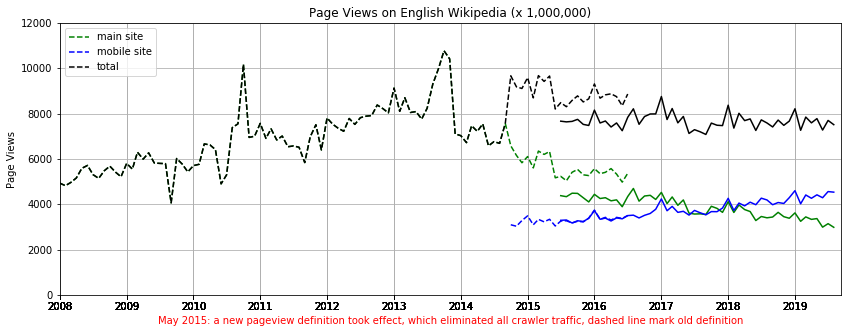

In [95]:
import matplotlib.pyplot as plt
UNIT=1000000
fig, ax = plt.subplots(figsize=(14,5))
desktop, = ax.plot_date(data['Date'], data['pagecount_desktop_views']/UNIT, 'g--')
mobile, = ax.plot_date(data['Date'], data['pagecount_mobile_views']/UNIT, 'b--')
total, = ax.plot_date(data['Date'], data['pagecount_all_views']/UNIT, 'k--')
ax.plot_date(data['Date'], data['pageview_desktop_views']/UNIT, 'g')
ax.plot_date(data['Date'], data['pageview_mobile_views']/UNIT, 'b')
ax.plot_date(data['Date'], data['pageview_all_views']/UNIT, 'k')

# limit x, y-axis boundary
plt.xlim(('2008-01-01', '2019-09-09'))
plt.ylim((0, 12000))
# This is to ensure we have a horizontal line for each year, which I spent an entire hour on it...
# Referencing https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_xticks.html
ax.set_xticks([d.strftime("%Y") for d in data['Date']])

plt.grid()

# adding labels and legend
plt.xlabel("May 2015: a new pageview definition took effect, which eliminated all crawler traffic, dashed line mark old definition",
          color='r')
plt.ylabel("Page Views")
plt.title("Page Views on English Wikipedia (x 1,000,000)")
mobile.set_label("mobile site")
total.set_label("total")
plt.legend((desktop, mobile, total), ('main site', 'mobile site', 'total'), loc="upper left")

plt.savefig('En-wikipedia_traffic_200801-201909_ywei1.png')